# Application with new data

This tutorial demonstrates deconvolution on new ST human pancreatic cancer data using Pysodb and Tangram.

This tutorial refers to the following tutorial at https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html. At the same time, the way of loadding data is modified by using Pysodb.

The single cell data utilized in the tutorial is directly available at https://figshare.com/articles/dataset/PDAC/22332574.

## Import packages and set configurations

In [1]:
# Import several Python packages, including:
# scanpy: a Python package for single-cell RNA sequencing analysis
import scanpy as sc
# squidpy: a Python package for spatial transcriptomics analysis
import squidpy as sq
# numpy: a Python package for scientific computing with arrays
import numpy as np
# pandas: a Python package for data manipulation and analysis
import pandas as pd
# anndata: a Python package for handling annotated data objects in genomics
import anndata as ad

In [2]:
# Import tangram for spatial deconvolution
import tangram as tg

In [3]:
# Print a header message, and the version of the squidpy and tangram packages
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tangram=={tg.__version__}")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8
squidpy==1.2.3
tangram==1.0.4


In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import palettable
# Define a list of color hex codes
adjusted_qualitative_colors = [
    '#5e81ac', '#f47b56', '#7eaca9', '#e28b90', '#ab81bd', '#b68e7e', '#df8cc4', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39'
]

# Create adjusted custom qualitative colormap
adjusted_qualitative_cmap = ListedColormap(adjusted_qualitative_colors)

# Example of using the custom colormap with Scanpy
# sc.pl.umap(adata, color='gene_name', cmap=adjusted_qualitative_cmap)

# Create a list of 10 soft pastel colormap
cmp_ct = palettable.cartocolors.qualitative.Pastel_10.mpl_colors

## Load a single cell dataset

In [5]:
# Read CSV files
#pd_sc = pd.read_csv('data/pdac/sc_data.csv')
#pd_sc_meta = pd.read_csv('data/pdac/sc_meta.csv')
pd_sc = pd.read_csv('data/pdac/sc_data.csv')
pd_sc_meta = pd.read_csv('data/pdac/sc_meta.csv')

In [6]:
# Set the index
pd_sc = pd_sc.set_index('Unnamed: 0')
pd_sc_meta = pd_sc_meta.set_index('Cell')

In [7]:
# Extract gene names and cell identifiers
sc_genes = np.array(pd_sc.index)
sc_obs = np.array(pd_sc.columns)
# Transpose the expression data
sc_X = np.array(pd_sc.values).transpose()

In [8]:
#Create an AnnData object
adata_sc = ad.AnnData(sc_X)
adata_sc.var_names = sc_genes
adata_sc.obs_names = sc_obs
# Add cell type information to the AnnData object
adata_sc.obs['CellType'] = pd_sc_meta['Cell_type'].values

In [9]:
# Print out the metadata of adata_sc
adata_sc

AnnData object with n_obs × n_vars = 1926 × 19104
    obs: 'CellType'

In [10]:
# Preprocess scRNA-seq data by selecting highly variable genes, normalizing expression values per cell, and applying a log transformation
sc.pp.highly_variable_genes(adata_sc, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)

In [11]:
# Perform dimensionality reduction and constructs a neighborhood graph
sc.pp.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.umap(adata_sc)

<Axes: title={'center': 'CellType'}, xlabel='UMAP1', ylabel='UMAP2'>

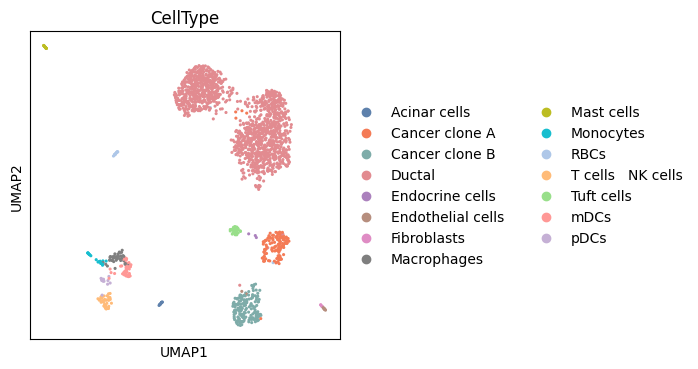

In [12]:
# Visualize the UMAP results 
fig,ax = plt.subplots(figsize=(4,4))
sc.pl.embedding(adata_sc,basis='umap',color=['CellType'],ax=ax,show=False,palette=adjusted_qualitative_colors,s=20)

## Streamline development of loading spatial data with Pysodb

In [13]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [14]:
# Initialization
sodb = pysodb.SODB()

In [15]:
# Define the name of the dataset_name and experiment_name
dataset_name = 'moncada2020integrating'
experiment_name = 'GSM3036911_spatial_transcriptomics'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata_st = sodb.load_experiment(dataset_name,experiment_name)

load experiment[GSM3036911_spatial_transcriptomics] in dataset[moncada2020integrating]


In [16]:
# Preprocess data
sc.pp.highly_variable_genes(adata_st, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_st, target_sum=1e4)
sc.pp.log1p(adata_st)

In [17]:
# Dimensionality reduction and neighborhood graph construction
sc.pp.pca(adata_st)
sc.pp.neighbors(adata_st)
sc.tl.umap(adata_st)
# Cluster cells using the Leiden algorithm
sc.tl.leiden(adata_st,resolution=0.7)

(0.5999999999999999, 31.4, 6.7, 35.3)

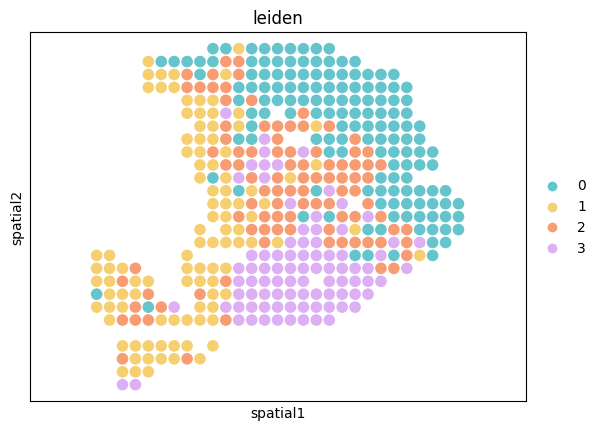

In [18]:
# Visualize the spatial embedding
ax = sc.pl.embedding(adata_st,basis='spatial',color=['leiden'],palette=cmp_ct,show=False)
ax.axis('equal')

## Preparation

In [19]:
# Perform differential gene expression analysis across 'CellType' in 'adata_sc'
sc.tl.rank_genes_groups(adata_sc, groupby="CellType", use_raw=False)

In [20]:
# Extract the top 100 marker genes per cell type from single-cell dataset
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
# Find unique marker genes
genes_sc = np.unique(markers_df.melt().value.values)
# Get gene names from spatial transcriptomics dataset
genes_st = adata_st.var_names.values
# Find the intersection of gene sets
genes = list(set(genes_sc).intersection(set(genes_st)))
# The length of "genes"
len(genes)

1103

## Perform Tangram for alignment

In [21]:
# Use the Tangram to align the gene expression profiles of "adata_sc" and "adata_st" based on the shared set of genes identified by the intersection of "genes_sc" and "genes_st".
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1079 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:13775 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [22]:
# Use the map_cells_to_space function from the tangram to map cells from "adata_sc")" onto "adata_st". 
# The mapping use "cells" mode, which assign each cell from adata_sc to a location within the spatial transcriptomics space based on its gene expression profile.
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    # target_count=adata_st.obs.cell_count.sum(),
    # density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1079 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.340, KL reg: 0.113
Score: 0.587, KL reg: 0.001
Score: 0.591, KL reg: 0.001
Score: 0.592, KL reg: 0.001
Score: 0.592, KL reg: 0.001
Score: 0.592, KL reg: 0.001
Score: 0.592, KL reg: 0.001
Score: 0.592, KL reg: 0.001
Score: 0.592, KL reg: 0.001
Score: 0.592, KL reg: 0.001


INFO:root:Saving results..


In [23]:
# Project "CellType" annotations from a single-cell RNA sequencing (scRNA-seq) dataset onto a spatial transcriptomics dataset, based on a previously computed cell-to-space mapping
tg.project_cell_annotations(ad_map, adata_st, annotation="CellType")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [24]:
# Create new columns in "adata_st.obs" that correspond to the values in "adata_st.obsm['tangram_ct_pred']"
for ct in adata_st.obsm['tangram_ct_pred'].columns:
    adata_st.obs[ct] = np.array(adata_st.obsm['tangram_ct_pred'][ct].values)

In [25]:
# Print adata_st.obsm['tangram_ct_pred']
adata_st.obsm['tangram_ct_pred']

,Acinar cells,Ductal,Cancer clone A,Cancer clone B,mDCs,Tuft cells,pDCs,Endocrine cells,Endothelial cells,Macrophages,Mast cells,T cells NK cells,Monocytes,RBCs,Fibroblasts
spots,,,,,,,,,,,,,,,
10x10,0.009497,6.672646,0.424408,0.368327,0.592680,0.037527,0.085090,0.006506,0.115381,0.300945,0.080646,0.312955,0.104370,0.022690,0.021423
10x13,0.004136,5.520368,0.069313,0.077433,0.118182,0.051383,0.015343,0.005291,0.016948,0.039191,0.044960,0.117301,0.099030,0.043749,0.002422
10x14,0.025058,4.375388,0.174041,0.484484,0.190605,0.016902,0.065869,0.004310,0.035297,0.112845,0.093955,0.062976,0.000027,0.035016,0.004687
10x15,0.042269,3.250308,0.125651,0.129064,0.094200,0.052903,0.071260,0.004727,0.039667,0.066190,0.031777,0.054321,0.117018,0.025751,0.004090
10x16,0.012410,3.084373,0.000099,0.031348,0.000151,0.083004,0.062752,0.004804,0.007365,0.032401,0.036338,0.237107,0.000112,0.003946,0.005928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9x29,0.005264,4.249710,0.000088,0.401962,0.194918,0.018993,0.034039,0.006070,0.059100,0.033828,0.031062,0.126530,0.000050,0.024517,0.000026
9x30,0.003174,2.255114,0.023105,0.211828,0.038126,0.077600,0.024611,0.004768,0.011907,0.083275,0.065433,0.099359,0.047894,0.003502,0.009234
9x31,0.013383,0.674886,0.325171,0.213344,0.129682,0.025250,0.032006,0.005734,0.009255,0.294749,0.004396,0.155496,0.019770,0.002794,0.004159


In [26]:
adata_st

AnnData object with n_obs × n_vars = 428 × 14576
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'clusters', 'leiden', 'uniform_density', 'rna_count_based_density', 'Acinar cells', 'Ductal', 'Cancer clone A', 'Cancer clone B', 'mDCs', 'Tuft cells', 'pDCs', 'Endocrine cells', 'Endothelial cells', 'Macrophages', 'Mast cells', 'T cells   NK cells', 'Monocytes', 'RBCs', 'Fibroblasts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm', 'n_cells', 'sparsity'
    uns: 'hvg', 'leiden', 'leiden_colors', 'moranI', 'neighbors', 'pca', 'rank_genes_groups', 'spatial_

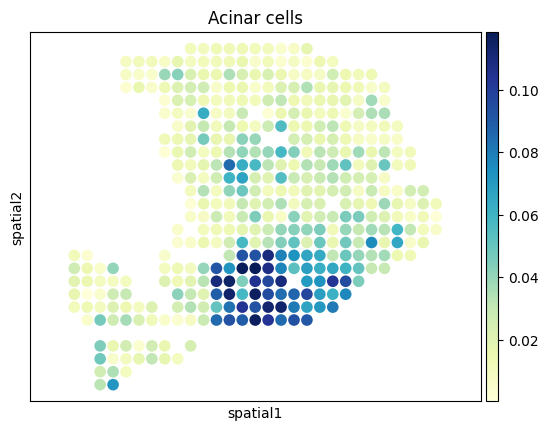

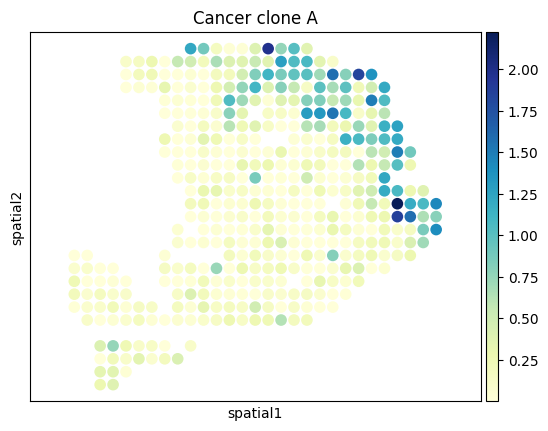

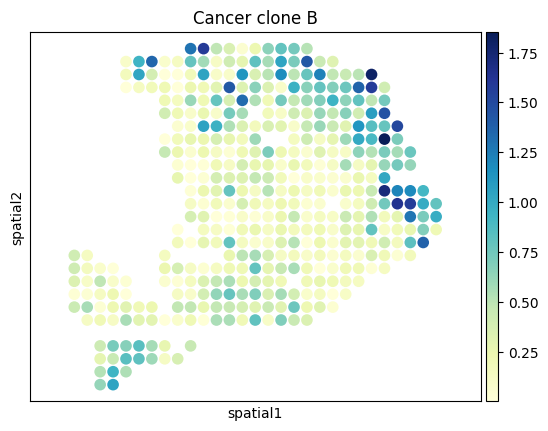

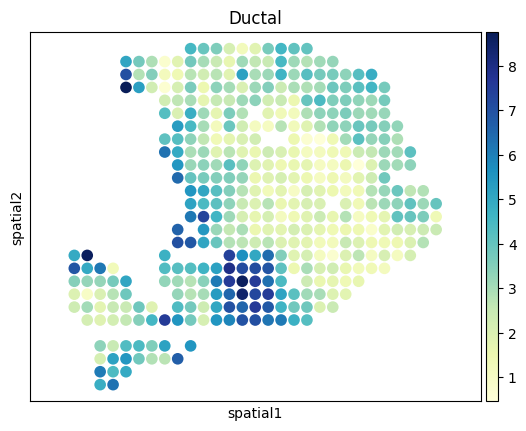

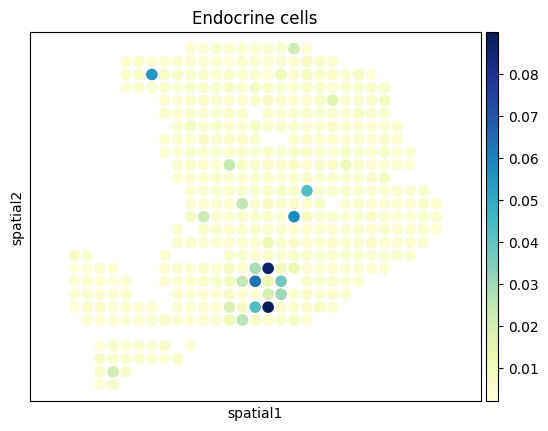

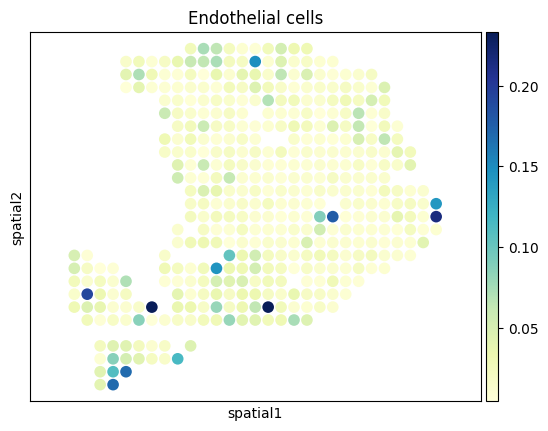

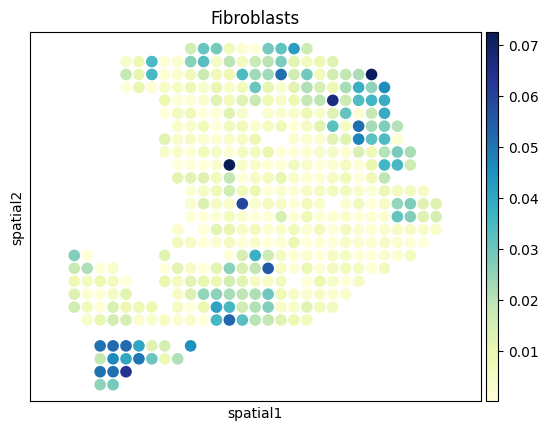

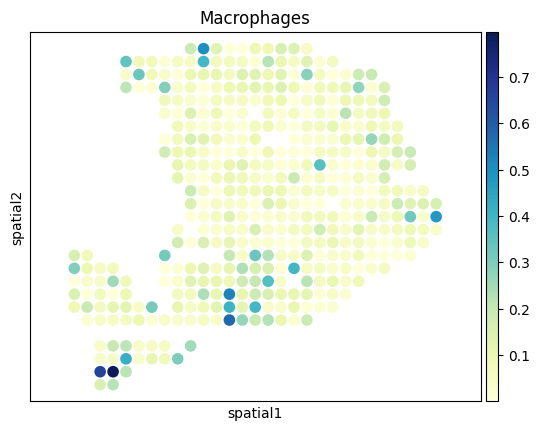

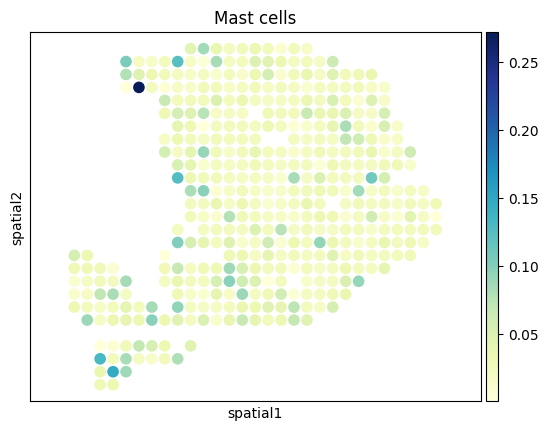

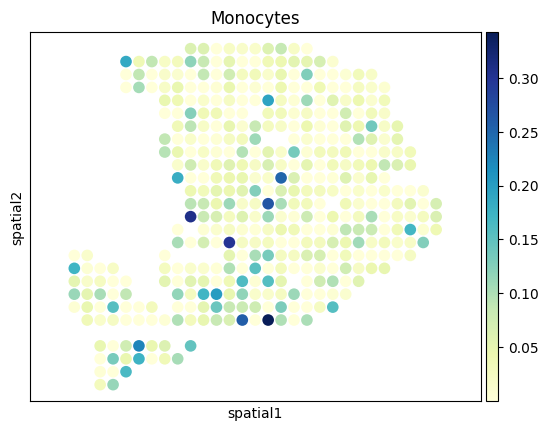

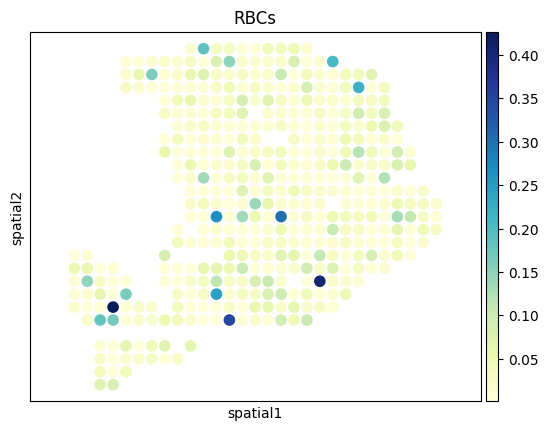

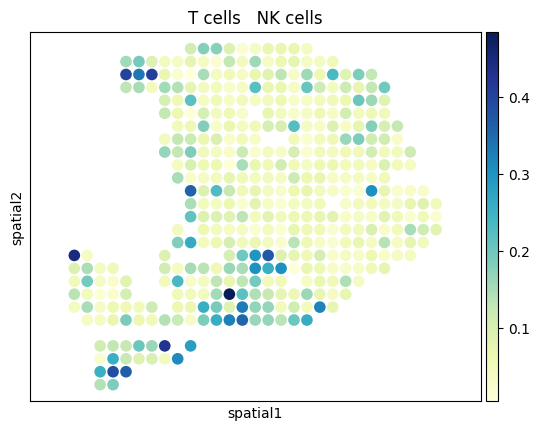

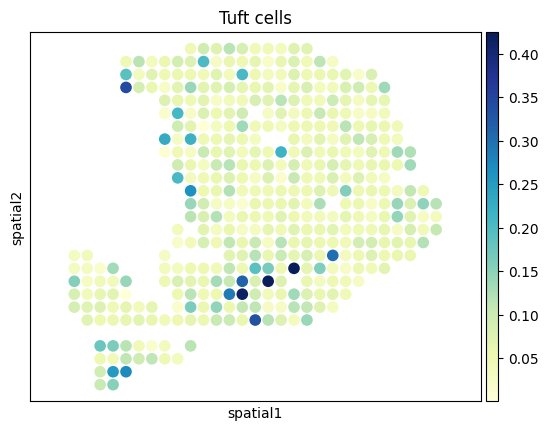

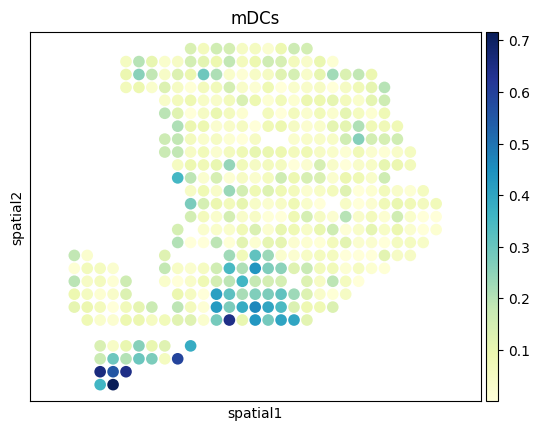

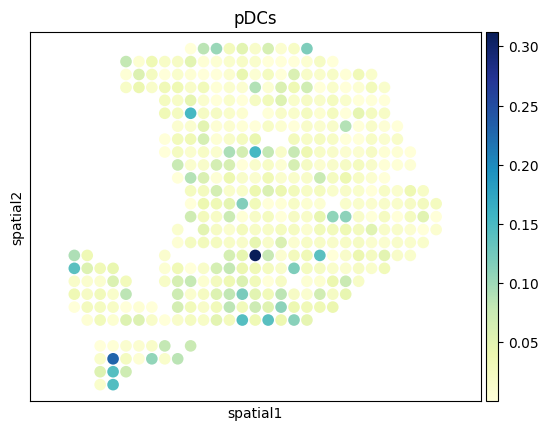

In [27]:
from palettable.colorbrewer.sequential import YlGnBu_9
# to_plot_list = ['Acinar cells','Cancer clone A','Cancer clone B','Ductal']
to_plot_list = adata_sc.obs['CellType'].cat.categories
for to_plot in to_plot_list:
    ax = sc.pl.embedding(
        adata_st,
        basis='spatial',
        color=to_plot,
        show=False,
        color_map=YlGnBu_9.mpl_colormap
    )
    ax.axis('equal')